# Causal Reasoning in Probability Trees 


Probability trees are one of the *simplest models of causal
generative processes*.They possess clean semantics and are strictly more general
than causal Bayesian networks, being able to e.g. represent causal relations
that causal Bayesian networks can’t. Discrete
probability trees cover the entire causal hierarchy (association,
intervention, and counterfactuals), operating on arbitrary **logical** and **causal
events**.



## What's a Probability Tree? 
A Probability Tree is a representation of a random experiment or process. Starting from the **root node**, the process iteratively takes **random transitions** to **child nodes**, terminating at a leaf node.
* A path from the root node to a node is a **partia realization**, and a path from the root node to a leaf node is a **total realization**
* Every node in the tree has one or more **statements** associeted with it.

### References 
* ["Algorithms
for Causal Reasoning in Probability trees"](https://arxiv.org/abs/2010.12237) by Genewein et al. (2020).
* [Probability Trees Code Tutorials](https://nbviewer.jupyter.org/github/COVID-19-Causal-Reasoning/probability_trees/tree/main/)
* ["Probabilistic programming for causality"](https://www.altdeep.ai/p/causal-ml-minicourse) 


In [3]:
import sys
from importlib.util import find_spec
if find_spec("causai") is None:
    sys.path.append('..')

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
import causai
from causai.probability_trees import MinCut, Critical, PTree
import pandas as pd


### Drug testing

Here we have a drug testing situation:

-   A patient has a probability of being ill ($D = 1$).
-   If the patient takes the drug ($T = 1$) when she is ill, she will likely
    feel better ($R = 1$), otherwise she will likely feel worse ($R = 0$).
-   However, if she takes the drug when she is not ill, the situation is
    inverted: the drug might make her feel worse ($R = 0$).

![Drug Testing CBN](http://www.adaptiveagents.org/_media/wiki/drug-testing.png)

This tree can also be represented as the above causal Bayesian graph. This is
always the case when the causal ordering of the random variables is the same, no
matter which realization path is taken in the tree.

Random variables: {'O': ['1'], 'D': ['0', '1'], 'T': ['0', '1'], 'R': ['0', '1']}


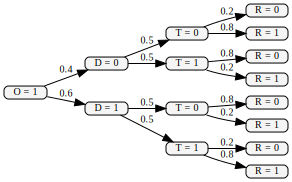

In [6]:
med = PTree() # create a blank probability tree 

# Add a root node and children
med.root('O = 1', [
    med.child(0.4, 'D = 0', [
        med.child(0.5, 'T = 0',
                  [med.child(0.2, 'R = 0'),
                   med.child(0.8, 'R = 1')]),
        med.child(0.5, 'T = 1',
                  [med.child(0.8, 'R = 0'),
                   med.child(0.2, 'R = 1')])
    ]),
    med.child(0.6, 'D = 1', [
        med.child(0.5, 'T = 0',
                  [med.child(0.8, 'R = 0'),
                   med.child(0.2, 'R = 1')]),
        med.child(0.5, 'T = 1',
                  [med.child(0.2, 'R = 0'),
                   med.child(0.8, 'R = 1')])
    ])
])

print('Random variables:', med.rvs())
display(med.show())

## Propositions and min-cuts

We've seen that a probability tree is a simple way of representing all the
possible realizations and their causal dependencies. We now investigate the
possible **events** in a probability tree.

An **event** is a collection of full realizations. We can **describe** events
using propositions about random variables (e.g. $W = 0$, $B = 1$) and the
logical connectives of negation, conjunction (AND), and disjunction (OR). 

The connectives allow us to state composite events.

We can **represent** events using cuts, and in particular, **min-cuts**. 

A **min-cut** is a minimal representation of an event in terms of the nodes of a
probability tree. Collects the smallest number of nodes
in the probability tree that resolves whether an **event has occurred or not**. 
 


Type of a cut: <class 'causai.probability_trees.MinCut'>
Min-cut for "R = 1": {true: {2, 5, 9, 12}, false: {1, 4, 8, 11}}


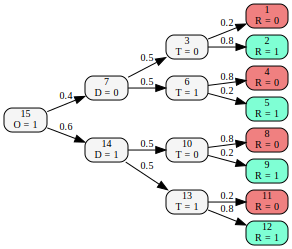

In [7]:
# Build a cut for the proposition 'R = 1'.
cut = med.prop('R=1')

# The result is of type MinCut:
print('Type of a cut:', type(cut))

# Print the min-cut. Note that the elements in the
# true and false sets refer to the ids of the prob tree.
print('Min-cut for "R = 1":', cut)

# Render the probability tree with a cut.
display(med.show(cut=cut, show_id=True))

Min-cut for "T = 0": {true: {3, 10}, false: {6, 13}}


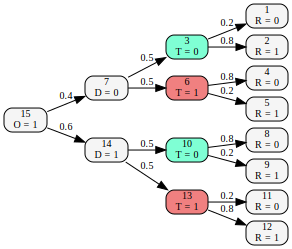

In [8]:
# Build a cut for the proposition 'T = 0'.
cut = med.prop('T=0')

# Print the min-cut. Note that the elements in the
# true and false sets refer to the ids of the prob tree.
print('Min-cut for "T = 0":', cut)

# Render the probability tree with a cut.
display(med.show(cut=cut, show_id=True))

Cut for "R = 1":


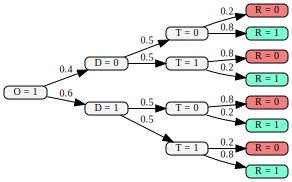

Cut for "T=1":


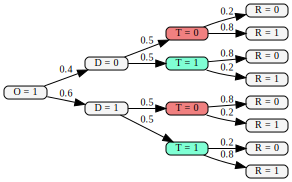

Cut for "T=1 and R=1":


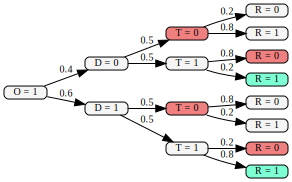

Cut for "T=1 or R=1":


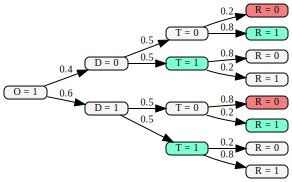

In [9]:
# Recovery
cut1 = med.prop('R=1')
print('Cut for "R = 1":')
display(med.show(cut=cut1))

# Taking the treatment
cut2 = med.prop('T=1')
print('Cut for "T=1":')
display(med.show(cut=cut2))

# Conjunction: taking the treatment and recovery
cut_and = cut1 & cut2
print('Cut for "T=1 and R=1":')
display(med.show(cut=cut_and))

# Disjunction: taking the treatment or recovery
cut_or = cut1 | cut2
print('Cut for "T=1 or R=1":')
display(med.show(cut=cut_or))


## Critical sets

Every min-cut has an associated **critical set**:
the set of nodes that **determines** whether an event **won't occur**. Given an
event, the associated **critical set** is defined as the set of parents of the
event's false set in the min-cut.

Together, a critical set and a min-cut form the set of **mechanisms** that
determine the occurrence of the event.

## Evaluating probabilities

We can also evaluate probabilities of events. For instance, you may ask:

-   "$P(R=1)$: What is the probability of recovery?"
-   "$P(R=0)$: What is the probability of not recovering?"
-   "$P(D=1)$: What is the probability of having the disease?"
-   "$P(D=1 \wedge R=0)$: What is the probability of taking the drug and not
    recovering?"
-   "$P(D=1 \vee R=0)$: What is the probability of taking the drug or not
    recovering?"
-   "$P(D=1 \prec R=1)$: What is the probability of taking the drug preceding
    the recovery?"

To do so, we use the min-cut of the event.

Let's have a look at some of them. Compare to the graph of the probability tree.




P(R=1) = 0.5
P(R=0) = 0.5
P(D=1) = 0.6
P(D=1 and R=0) = 0.3
P(D=1 or R=0) = 0.8
P(D=1 precedes R=1) = 0.3


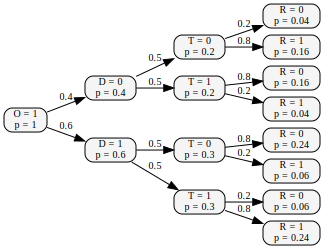

In [10]:
# Min-cuts for some events
cut1 = med.prop('R=1')
cut2 = med.prop('D=1')
cut1_neg = ~cut1
cut_and = cut2 & cut1_neg
cut_or = cut2 | cut1_neg
cut_prec = cut2 < cut1

print('P(R=1) =', med.prob(cut1))
print('P(R=0) =', med.prob(cut1_neg))
print('P(D=1) =', med.prob(cut2))
print('P(D=1 and R=0) =', med.prob(cut_and))
print('P(D=1 or R=0) =', med.prob(cut_or))
print('P(D=1 precedes R=1) =', med.prob(cut_prec))

display(med.show(show_prob=True))

## Conditioning

We have learned how to represent events using min-cuts. Now we can use min-cuts
to **condition** probability trees **on events**. Conditioning allows asking
questions after making **observations**, such as:

-   "$P(R=1|T=1)$: What is the probability of recovery given that a patient has
    taken the treatment?"
-   "$P(D=1|R=1)$: What is the probability of having had the disease given that
    a patient has recovered/felt better?"

We can condition on composite events too and evaluate the probability of events.

Assume you observe that the drug was taken and a recovery is observed. Then, it
is very likely that the patient had the disease.

P(D = 1) = 0.6
P(D = 1 | R = 1) = 0.6
P(D = 1 | T = 1, R = 1) = 0.857142857142857

Probability tree after conditioning on "T=1 and R=1":


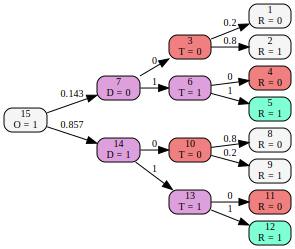

In [11]:
# Min-cuts.
cut_r = med.prop('R=1')
cut_tr = med.prop('T=1') & med.prop('R=1')
cut_disease = med.prop('D=1')

# Critical set.
crit = med.critical(cut_tr)

# Condition.
med_see_r = med.see(cut_r)
med_see_tr = med.see(cut_tr)

# Now we evaluate the posterior probability of having a disease.
print('P(D = 1) =', med.prob(cut_disease))
print('P(D = 1 | R = 1) =', med_see_r.prob(cut_disease))
print('P(D = 1 | T = 1, R = 1) =', med_see_tr.prob(cut_disease))

# Display prob tree.
print('\nProbability tree after conditioning on "T=1 and R=1":')
display(med_see_tr.show(cut=cut_tr, show_id=True, crit=crit))

## Interventions

An **intervention** is a change to the random process
itself to make something happen, as opposed to a filtration. We can ask
questions like:

-   "$P(R=1|T \leftarrow 1)$: What is the probability of recovery given that **I
    take the drug**?"
-   "$P(D=1|T \leftarrow 1 \wedge R=1)$: What is the probability of having the
    disease given **that I take the drug** and that I observe a recovery?"

Here, the notation $T \leftarrow 1$ is a shorthand for the more common notation
$\mathrm{do}(T = 1)$.

We investigate the effect of taking
the treatment, that is, by intervening on $T \leftarrow 1$. How do the
probabilities of: 
- having the disease ($D = 1$); 
- taking the treatment ($T = 1$); 
- and recovering ($R = 1$)

change after taking the treatment ($T \leftarrow 1$)?


Original tree:
P(D = 1) = 0.6
P(T = 1) = 0.5
P(R = 1) = 0.5


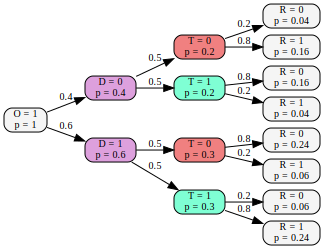

Tree after intervening on "T <- 1":
P(D = 1 | T <- 1) = 0.6
P(T = 1 | T <- 1) = 1.0
P(R = 1 | T <- 1) = 0.56


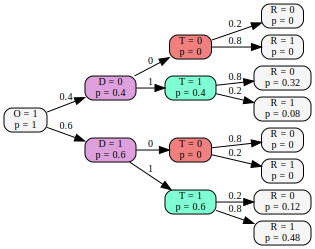

In [12]:
# Min-Cuts.
cut_dis = med.prop('D = 1')
cut_arg = med.prop('R = 1')
cut_do = med.prop('T = 1')

# Critical set.
crit_do = med.critical(cut_do)

# Perform intervention.
med_do = med.do(cut_do)

# Display original tree.
print('Original tree:')
print('P(D = 1) =', med.prob(cut_dis))
print('P(T = 1) =', med.prob(cut_do))
print('P(R = 1) =', med.prob(cut_arg))
display(med.show(cut=cut_do, show_prob=True, crit=crit_do))

# Display tree after invervention.
print('Tree after intervening on "T <- 1":')
print('P(D = 1 | T <- 1) =', med_do.prob(cut_dis))
print('P(T = 1 | T <- 1) =', med_do.prob(cut_do))
print('P(R = 1 | T <- 1) =', med_do.prob(cut_arg))
display(med_do.show(cut=cut_do, show_prob=True, crit=crit_do))

For the example above taking the treatment increases the
chances of recovery. This is due to the base rates (i.e. the probability of
having a disease). The base rates are not affected by the decision of taking the
treatment.

## Counterfactuals

Counterfactuals are questions about how the
experiment could have gone if something about it were different. For instance:

-   "What is the probability of having the disease **had I not recovered**,
    given that I have recovered?"
-   "Given that I have taken the treatment and recovered, what is the
    probability of recovery **had I not taken the treatment**?"

These are tricky questions because they mix two moods:

-   **indicative statements** - things that have actually happened;
-   **subjunctive statements** - things that could have happened 
in an alternate reality/possible world.

Because of this, counterfactuals spawn a new scope of random variables:

<img src="http://www.adaptiveagents.org/_media/wiki/counterfactual.png" alt="Counterfactual" width="400"/>

These two questions above are spelled as follows:

-   $P(D^\ast=1|R=1)$, where $D^\ast=D_{R \leftarrow 0}$
-   $P(R^\ast=1|T\leftarrow 1; R=1)$, where $R^\ast=R_{T\leftarrow 0}$

Here the random variables with an asterisk $D^\ast, R^\ast$ are copies of the
original random variables $D, R$ that ocurr in an alternate reality. The
notation $D_{T \leftarrow 0}$ means that the random variable $D$ is in the new
scope spawned by the intervention on $T\leftarrow 0$.


### "What is the probability of having the disease **had I not recovered**, given that I have recovered?"

$$P(D^\ast=1|R=1), \qquad D^\ast=D_{R \leftarrow 0}.$$

Baseline:
P(D = 1) = 0.6


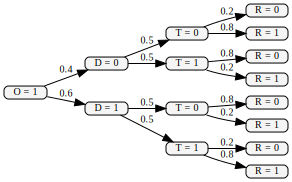

Premise:
P(D = 1 | R = 1) = 0.6


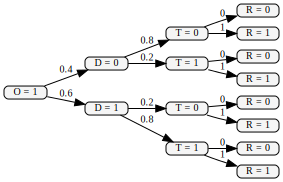

Counterfactual:
P(D* = 1 | R = 1) = 0.6 , D* = D[R <- 0]


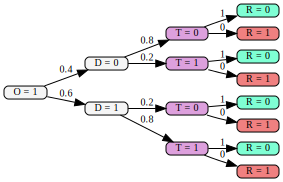

In [13]:
# Cuts.
cut_disease = med.prop('D = 1')
cut_recovery = med.prop('R = 1')
cut_not_recovery = ~cut_recovery

# Critical.
crit = med.critical(cut_not_recovery)

# Compute counterfactual:
# - compute factual premise,
# - use factual premise and subjunctive premise to compute counterfactual.
med_factual_prem = med.see(cut_recovery)
med_cf = med.cf(med_factual_prem, cut_not_recovery)

print('Baseline:')
print('P(D = 1) =', med.prob(cut_disease))
display(med.show())
print('Premise:')
print('P(D = 1 | R = 1) =', med_factual_prem.prob(cut_disease))
display(med_factual_prem.show())
print('Counterfactual:')
print('P(D* = 1 | R = 1) =', med_cf.prob(cut_disease), ', D* = D[R <- 0]')
display(med_cf.show(crit=crit, cut=cut_not_recovery))

### Example 

Consider the drug testing probability tree `med`.

-   Assume you take the drug ($T \leftarrow 1$) and you feel bad afterwards
    ($R = 0$).
-   Given this information, what is the probability of recovery ($R = 1$) had
    you not taken the drug ($T = 0$)?

Compute the **regret**, i.e. the difference: $$ \mathbb{E}[ R^\ast | T \leftarrow 1; R = 0 ] - \mathbb{E}[ R | T \leftarrow 1; R = 0 ], $$ where $R^\ast = R_{T \leftarrow 0}$.

P(R* = 1 | T <- 1, R = 0) = 0.6363636363636365
Regret =  0.6363636363636365


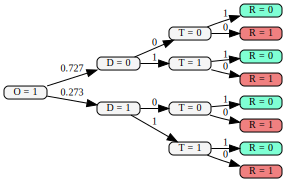

In [14]:
med_prem = med.do(med.prop('T=1')).see(med.prop('R=0'))
med_cf = med.cf(med_prem, med.prop('T=0'))

print('P(R* = 1 | T <- 1, R = 0) =', med_cf.prob(med.prop('R=1')))

regret = med_cf.expect('R') - med_prem.expect('R')
print('Regret = ', regret)

display(med_prem.show(cut=med.prop('R=0')))